#One pixel attack for fooling deep networks

Implementation of the one pixel attack described in ["One pixel attack for fooling deep networks"](https://arxiv.org/abs/1710.08864)  by Jiawei Su, Danilo Vasconcellos Vargas, Sakurai Kouichi.  
The structure of the code is inspired from this GitHub repository by [Dan Kondratyuk](https://github.com/Hyperparticle/one-pixel-attack-keras).

##Preprocessing and utility
Loading of modules and dataset, preprocessing of dataset, utility functions

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.python.keras.layers import Dense,Flatten
from tensorflow.keras import datasets
from tensorflow.keras.datasets import cifar10
import cv2
from timeit import default_timer as timer
#from keras import backend as K

In [ ]:
(x_train,y_train),(x_test,y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 11s 0us/step


In [ ]:
Labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
def plot_image(image, true_label, prediction, save = False, id = None):
  t_label = Labels[true_label[0]]
  p_label = Labels[np.argmax(prediction)]
  confidence = str(round(np.max(prediction)*100,2)) +"%"
  plt.figure(figsize=(2,2))
  # the images gets modified by the resnet preprocessing and have to be reconverted from BGR to RGB
  #and brought in [0,1]
  plt.imshow((cv2.cvtColor(image,cv2.COLOR_BGR2RGB)+128)/255) 
  plt.title(f"True label:{t_label}\nPredicted Label:{p_label} with confidence {confidence}")
  if save:
    plt.savefig('image'+id+'.png',bbox_inches='tight')
  plt.show()

In [ ]:
def perturb_image(image, perturbation):
  perturbed_image = image.copy()
  x,y,r,g,b = perturbation #perturbations are tuples
  #x and y have to integers!!
  x = int(x) 
  y = int(y)
  perturbed_image[x][y]=np.array([r,g,b],dtype='uint8')
  return perturbed_image

In [ ]:
def one_hot(label):
  oh = [1 if label==i else 0 for i in range(10)]
  return oh

In [ ]:
#one hot encoding for training and evaluating
y_train_oh = np.array([one_hot(i)for i in y_train])
y_test_oh = np.array([one_hot(i)for i in y_test])

In [ ]:
#preprocess image to allow single sample prediction
def preprocess(image):
  return np.array([image,])

In [ ]:
#outputs the correct images of the dataset given
def corrects(model, data, labels):
  predictions = (model.predict(data))
  correct_imgs = []
  for i in range(len(predictions)):
    if labels[i] == np.argmax(predictions[i]):
      correct_imgs.append(i)
  return correct_imgs

##Pretraining model

Here we load pretrained models, but I actually use only the resnet50, can be interesting to see how different models respond to the attacks

###Resnet50


In [ ]:
my_resnetmodel = tf.keras.models.Sequential()

pretrained_model = tf.keras.applications.ResNet50(include_top=False, input_shape=x_train[0].shape, classes = 10)
resnet_preprocess = tf.keras.applications.resnet50.preprocess_input

x_train_rn = resnet_preprocess(x_train)
x_test_rn = resnet_preprocess(x_test)

for layer in pretrained_model.layers:
  layer.trainable = False

my_resnetmodel.add(pretrained_model)
my_resnetmodel.add(Flatten())
my_resnetmodel.add(Dense(512, activation = 'selu'))
my_resnetmodel.add(Dense(10, activation='softmax'))

In [ ]:
my_resnetmodel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 module_wrapper_6 (ModuleWra  (None, 2048)             0         
 pper)                                                           
                                                                 
 module_wrapper_7 (ModuleWra  (None, 512)              1049088   
 pper)                                                           
                                                                 
 module_wrapper_8 (ModuleWra  (None, 10)               5130      
 pper)                                                           
                                                                 
Total params: 24,641,930
Trainable params: 1,054,218
Non-trainable params: 23,587,712
__________________________________

In [ ]:
my_resnetmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
my_resnetmodel.fit(x_train_rn,y_train_oh, epochs = 5, batch_size = 128)

Epoch 1/5
391/391 [==============================] - 211s 528ms/step - loss: 1.3083 - accuracy: 0.6069
Epoch 2/5
391/391 [==============================] - 206s 526ms/step - loss: 0.8263 - accuracy: 0.7085
Epoch 3/5
391/391 [==============================] - 206s 526ms/step - loss: 0.6737 - accuracy: 0.7595
Epoch 4/5
391/391 [==============================] - 205s 523ms/step - loss: 0.5315 - accuracy: 0.8082
Epoch 5/5
391/391 [==============================] - 203s 520ms/step - loss: 0.3993 - accuracy: 0.8591


In [ ]:
my_resnetmodel.evaluate(x_test_rn, y_test_oh)

313/313 [==============================] - 50s 154ms/step - loss: 1.1571 - accuracy: 0.6576


[1.157072901725769, 0.6575999855995178]

My model is not very accurate and it overfits a bit, but the main point of the notebook is the attack.  
Here we collect the correctly classified images by the model.

In [ ]:
resnet_corrects = corrects(my_resnetmodel, x_test_rn, y_test)

313/313 [==============================] - 48s 150ms/step


###Other

In [ ]:
#my_resnetmodel2 = tf.keras.models.Sequential()

#pretrained_model = tf.keras.applications.ResNet50V2(include_top=False, input_shape=x_train[0].shape, classes = 10)

#for layer in pretrained_model.layers:
#  layer.trainable = False

#my_resnetmodel2.add(pretrained_model)
#my_resnetmodel2.add(Flatten())
#my_resnetmodel2.add(Dense(512, activation = 'selu'))
#my_resnetmodel2.add(Dense(10, activation='softmax'))

In [ ]:
#my_resnetmodel2.summary()

In [ ]:
#my_resnetmodel2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#my_resnetmodel2.fit(x_train,y_train_oh, epochs = 10, batch_size = 256)

##Attack
Here I perform the attack

###Function definition

In [ ]:
import scipy
differential_evolution = scipy.optimize.differential_evolution

In [ ]:
def attack_success(model, image, perturbation, true_label, target = None):
  
  perturbed_image = perturb_image(image,perturbation)
  predictions = model(preprocess(perturbed_image))[0]
  
  if target == None: #untargeted attack
    result = np.argmax(predictions)!=true_label 
    return result if result else None
  else: #targeted attack
    result = np.argmax(predictions)==target
    return result if result else None
  #return None if the attack is unsuccessful due to differential_evolution requirements

In [ ]:
def function_to_minimize(model, image, perturbation, true_label, target = None):
  
  perturbed_image = perturb_image(image, perturbation)
  predictions = model(preprocess(perturbed_image))[0]

  if target == None: #untargeted attack
    return float(predictions[true_label])
  else: #targeted attack
    return 1 - float(predictions[target])

In [ ]:
def attack(model, image, true_label, target=None):
  
  def callback(x,convergence):
    return attack_success(model, image, x, true_label, target)
  
  def function(x):
    return function_to_minimize(model, image, x, true_label, target)
  
  bounds = [(0,32),(0,32),(-128,128),(-128,128),(-128,128)] #x,y,r,g,b bounds

  if np.argmax(model(preprocess(image)))==true_label: # start the attack if the model classify correctly!!
    result = differential_evolution(func = function, 
                                    bounds = bounds, callback = callback, 
                                    maxiter = 10, mutation = 0.5, popsize = 20
                                    )# recombination =1, atol = -1)
    return result
  else:
    print('model is already wrong!!')
    return -1

###Untargeted

####The attack

In [ ]:
succ_att_u = [] # here the index of the image, the perturbation and the time is stored

In [ ]:
for i in resnet_corrects[:300]:
  start = timer()
  r = attack(my_resnetmodel, x_test_rn[i], y_test[i][0])
  end = timer()
  p = (r.x[0],r.x[1],r.x[2],r.x[3],r.x[4])
  if attack_success(my_resnetmodel, x_test_rn[i], p, y_test[i][0]): # the algorithm can stop even when the attack is not successful
    print('one attack has been successful',i)
    succ_att_u.append((i,p,end-start))

one attack has been successful 0
one attack has been successful 3
one attack has been successful 4
one attack has been successful 5
one attack has been successful 6
one attack has been successful 7
one attack has been successful 11
one attack has been successful 13
one attack has been successful 14
one attack has been successful 15
one attack has been successful 16
one attack has been successful 18
one attack has been successful 21
one attack has been successful 22
one attack has been successful 23
one attack has been successful 29
one attack has been successful 30
one attack has been successful 37
one attack has been successful 40
one attack has been successful 41
one attack has been successful 46
one attack has been successful 50
one attack has been successful 51
one attack has been successful 52
one attack has been successful 54
one attack has been successful 55
one attack has been successful 56
one attack has been successful 57
one attack has been successful 61
one attack has been 

In [ ]:
len(succ_att_u) # how many success did we have

215

In [ ]:
#total time
time = 0
for x in succ_att_u:
  _,_,t = x
  time+=t
print('total succesfull attack time: ',time)

total succesfull attack time:  9084.979887844009


time for attacking this image: 31.44987643500008


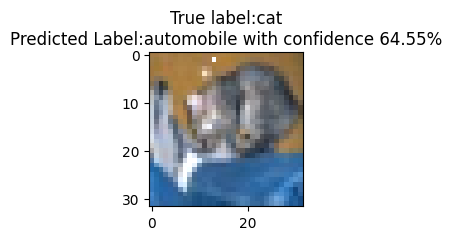

time for attacking this image: 31.091926921999857


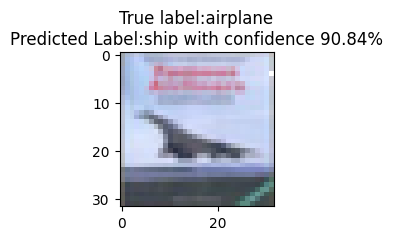

time for attacking this image: 30.447431152999798


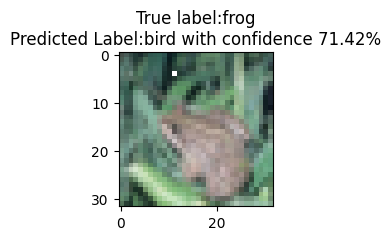

time for attacking this image: 30.384242537999853


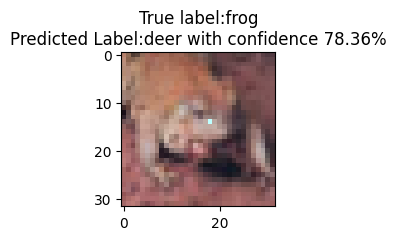

time for attacking this image: 31.28957199300021


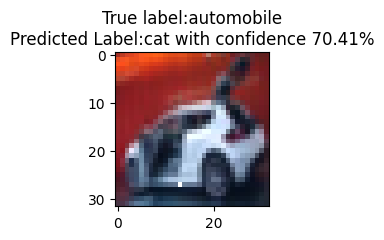

In [ ]:
#print some images
for x in succ_att_u[:5]:
  i,p,t = x
  image = perturb_image(x_test_rn[i],p)
  #image = x_test_rn[i]
  t_label = y_test[i]
  pred = my_resnetmodel(preprocess(image))
  print('time for attacking this image:',t)
  plot_image(image, t_label, pred)# save = True, id=str(i)+'mod')
  #files.download('image'+str(i)+'mod.png')

####Confusion Matrix

In [ ]:
#building a confusion matrix
conf_matrix = np.zeros((10,10))
for x in succ_att_u:
  i,p,t = x
  image = perturb_image(x_test_rn[i],p)
  #image = x_test_rn[i]
  t_label = y_test[i]
  pred = np.argmax(my_resnetmodel(preprocess(image)))
  conf_matrix[pred,t_label]+=1

In [ ]:
for i in range(10):
  print(f'examples in class {i}: {conf_matrix[:,i].sum()}')

examples in class 0: 21.0
examples in class 1: 18.0
examples in class 2: 20.0
examples in class 3: 17.0
examples in class 4: 20.0
examples in class 5: 20.0
examples in class 6: 28.0
examples in class 7: 19.0
examples in class 8: 29.0
examples in class 9: 23.0


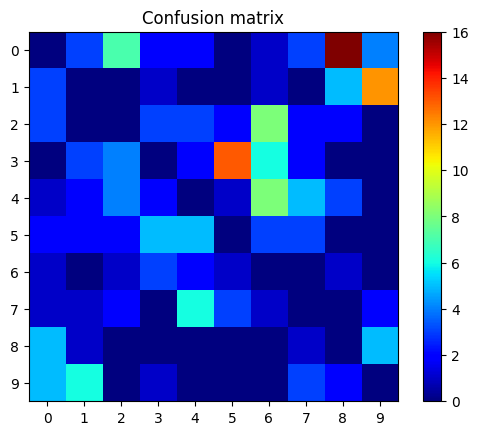

In [ ]:
plt.imshow(conf_matrix, cmap='jet')
plt.colorbar()
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.yticks([0,1,2,3,4,5,6,7,8,9])
plt.savefig('confusion_matrix_untargeted_attack')
plt.title('Confusion matrix')
plt.show()

####Perturbation visualization

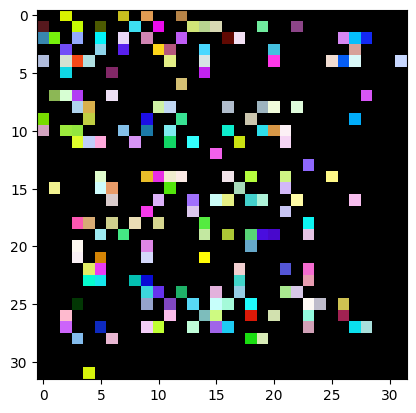

In [ ]:
#all perturbation together
b = np.zeros_like(x_test[0])
for i in succ_att_u:
  _,p,_ = i
  b= perturb_image(b, p)
  plt.imshow(b)
plt.savefig('all_perturbations')

In [ ]:
#perturbations per class
b = [np.zeros_like(x_test[0]) for i in range(10)]
for x in succ_att_u:
  i,p,_ = x
  pred = np.argmax(my_resnetmodel(preprocess(x_test_rn[i])))
  b[pred]= perturb_image(b[pred], p)

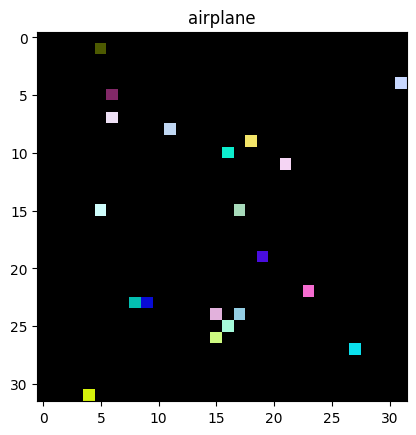

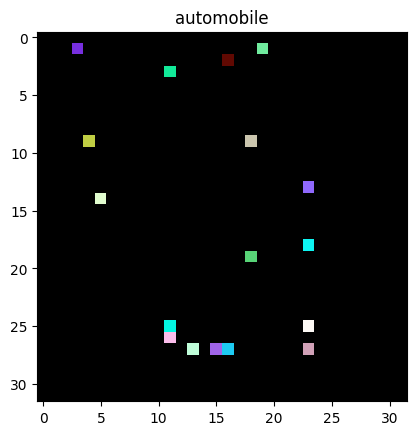

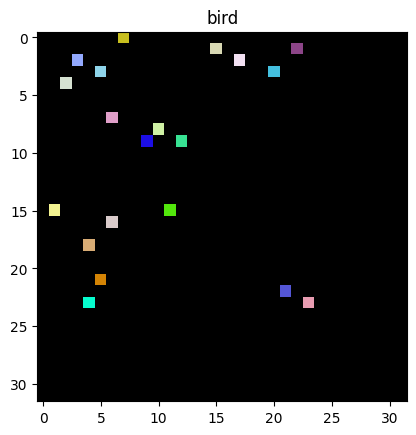

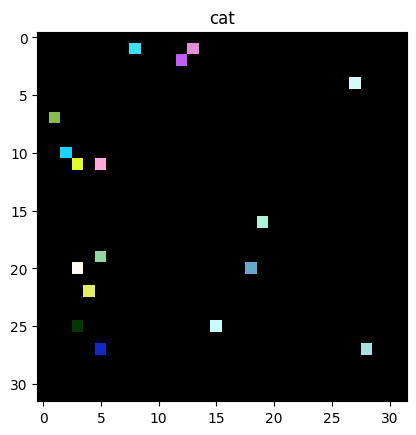

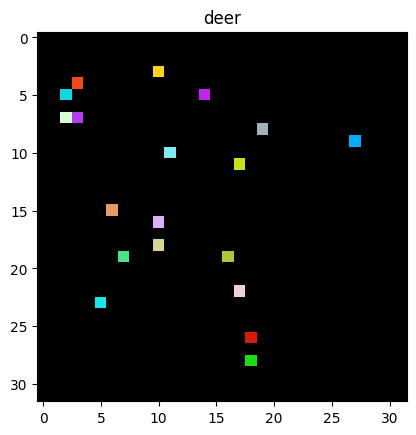

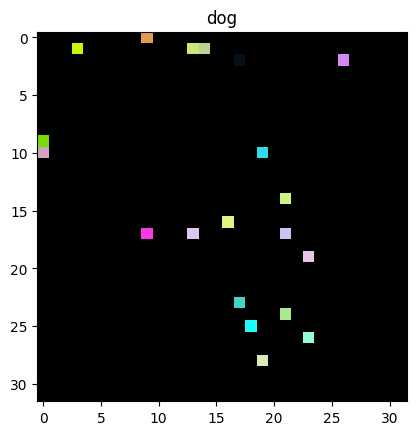

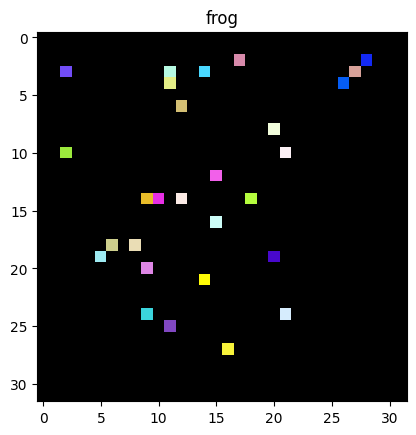

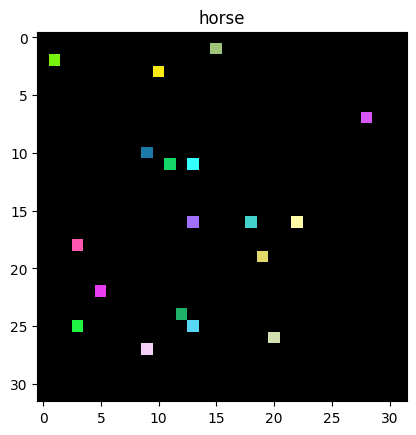

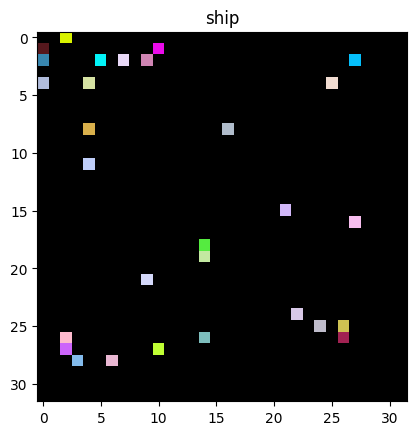

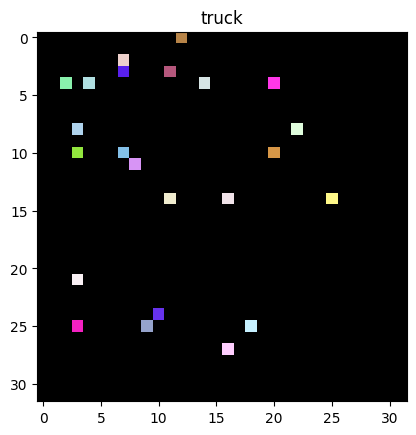

In [ ]:
for i in range(10):
  plt.imshow(b[i])
  plt.title(Labels[i])
  plt.show()

####Single image attack

In [ ]:
#chose an image and attack it multiple times
idx = 6
auto_image = x_test_rn[idx]
t_label = y_test[idx]
pred = my_resnetmodel(preprocess(image))
plot_image(auto_image, t_label, pred)# save = True, id='car')
  #files.download('image'+str(i)+'mod.png')


In [ ]:
auto_perturbations = []
for i in range(50):
  start = timer()
  r = attack(my_resnetmodel, auto_image, t_label[0])
  end = timer()
  p = (r.x[0],r.x[1],r.x[2],r.x[3],r.x[4])
  if attack_success(my_resnetmodel, auto_image, p, t_label[0]):
    print('one attack has been successful',i)
    auto_perturbations.append((p,end-start))

one attack has been successful 0
one attack has been successful 1
one attack has been successful 2
one attack has been successful 3
one attack has been successful 4
one attack has been successful 5
one attack has been successful 6
one attack has been successful 7
one attack has been successful 8
one attack has been successful 9
one attack has been successful 10
one attack has been successful 11
one attack has been successful 12
one attack has been successful 13
one attack has been successful 14
one attack has been successful 15
one attack has been successful 16
one attack has been successful 17
one attack has been successful 18
one attack has been successful 19
one attack has been successful 20
one attack has been successful 21
one attack has been successful 22
one attack has been successful 23
one attack has been successful 24
one attack has been successful 25
one attack has been successful 26
one attack has been successful 27
one attack has been successful 28
one attack has been succ

time for attacking this image: 32.78490966899699


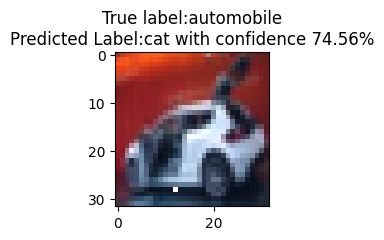

time for attacking this image: 34.19212978699943


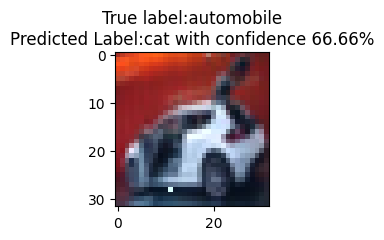

time for attacking this image: 31.287555024999165


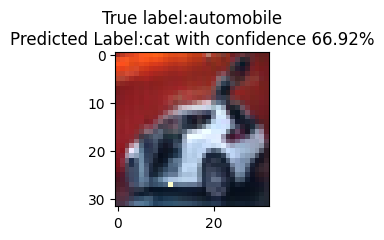

time for attacking this image: 32.9784692409994


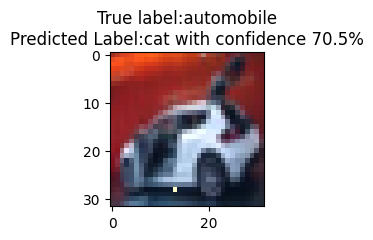

time for attacking this image: 31.141611916998954


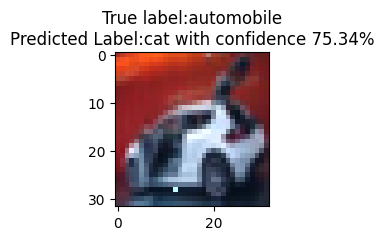

In [ ]:
for x in auto_perturbations[:5]:
  p,t = x
  image = perturb_image(auto_image,p)
  #image = x_test_rn[i]
  pred = my_resnetmodel(preprocess(image))
  print('time for attacking this image:',t)
  plot_image(image, t_label, pred)# save = True, id=str(i)+'mod')
  #files.download('image'+str(i)+'mod.png')

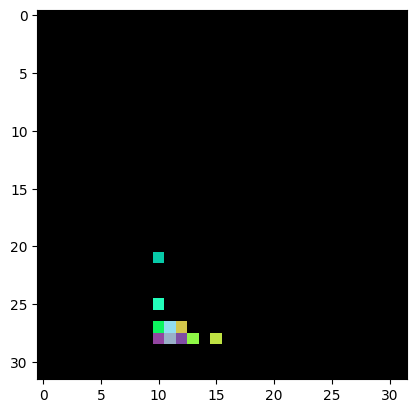

In [ ]:
b = np.zeros_like(x_test[0])
for i in auto_perturbations:
  p,_ = i
  b = perturb_image(b, p)
  plt.imshow(b)
plt.savefig('all_perturbations_car')

###Targeted

In [ ]:
succ_att_t=[]
for i in resnet_corrects[:100]:
  start = timer()
  r = attack(my_resnetmodel, x_test_rn[i], y_test[i][0], 9 - y_test[i][0]) #let's choose a target
  end = timer()
  p = (r.x[0],r.x[1],r.x[2],r.x[3],r.x[4])
  if attack_success(my_resnetmodel, x_test_rn[i], p, y_test[i][0], 9 - y_test[i][0]):
    print('one attack has been successful',i)
    succ_att_t.append((i,p,end-start))

one attack has been successful 5
one attack has been successful 18
one attack has been successful 22
one attack has been successful 30
one attack has been successful 50
one attack has been successful 52
one attack has been successful 57
one attack has been successful 62
one attack has been successful 64
one attack has been successful 68
one attack has been successful 77
one attack has been successful 79
one attack has been successful 91
one attack has been successful 94
one attack has been successful 95
one attack has been successful 103
one attack has been successful 108
one attack has been successful 125
one attack has been successful 127
one attack has been successful 131
one attack has been successful 136
one attack has been successful 140
one attack has been successful 146
one attack has been successful 148
one attack has been successful 149
one attack has been successful 150


In [ ]:
len(succ_att_t)

26

time for attacking this image: 31.117359547002707


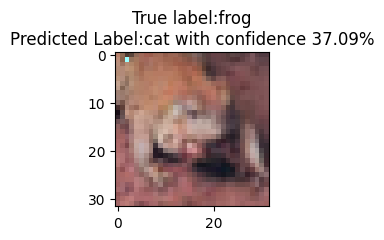

time for attacking this image: 30.928040006998344


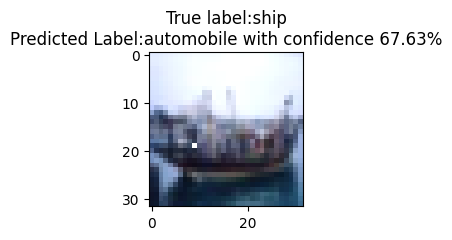

time for attacking this image: 104.03792241799965


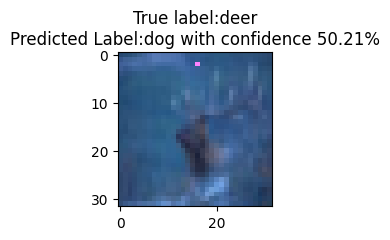

time for attacking this image: 46.472232089996396


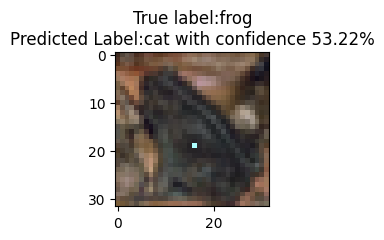

time for attacking this image: 30.796380389998376


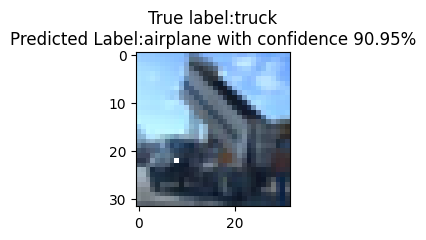

time for attacking this image: 46.37289513399446


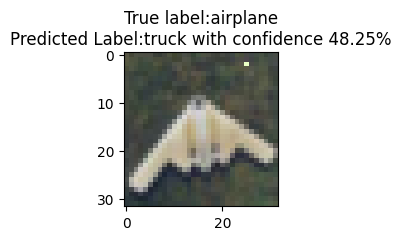

time for attacking this image: 30.639842608994513


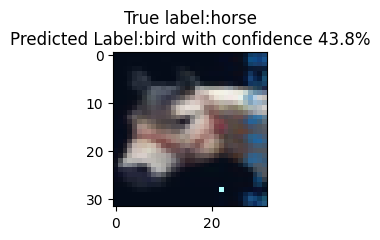

time for attacking this image: 31.84887753899966


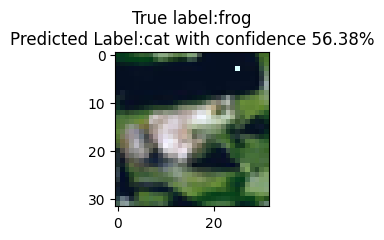

time for attacking this image: 62.165585213995655


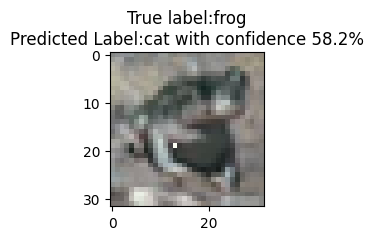

time for attacking this image: 30.529797276001773


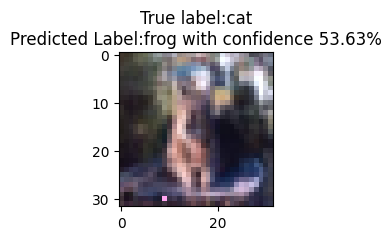

time for attacking this image: 31.154586297001515


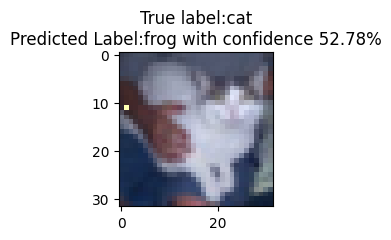

time for attacking this image: 108.30328974199801


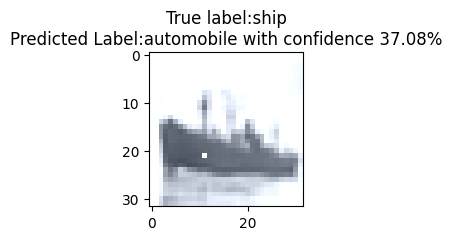

time for attacking this image: 45.22128598800191


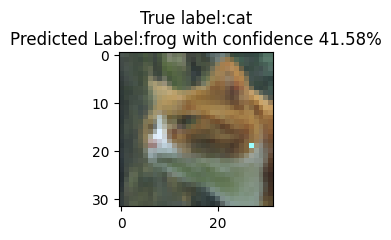

time for attacking this image: 30.922675620997325


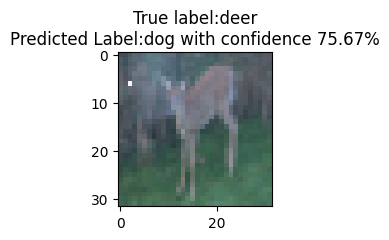

time for attacking this image: 30.726439815996855


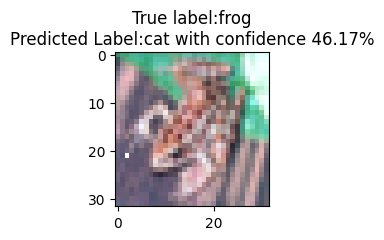

time for attacking this image: 30.314118445996428


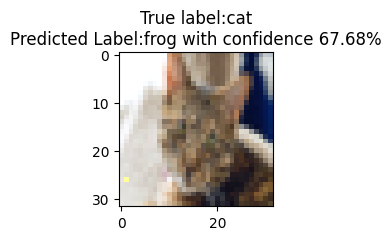

time for attacking this image: 31.416751556993404


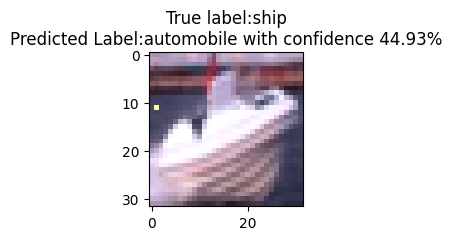

time for attacking this image: 30.694566070000292


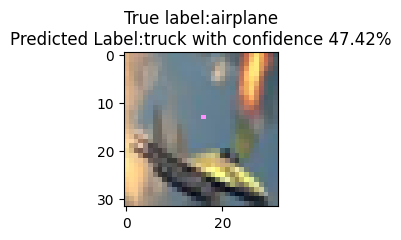

time for attacking this image: 47.52458430600382


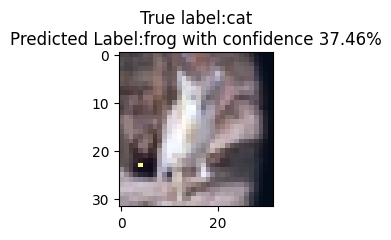

time for attacking this image: 168.4010529100051


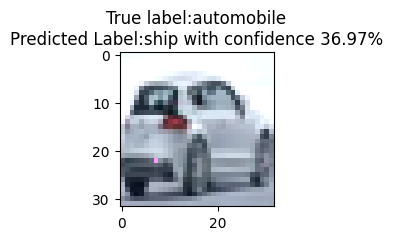

time for attacking this image: 91.28694566599734


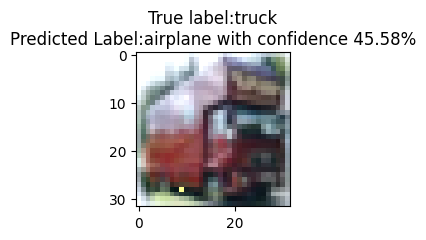

time for attacking this image: 46.854376108


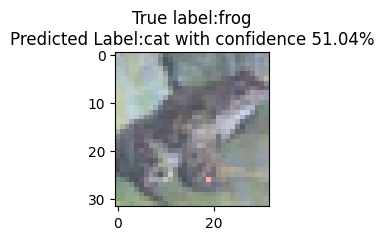

time for attacking this image: 31.50692361700203


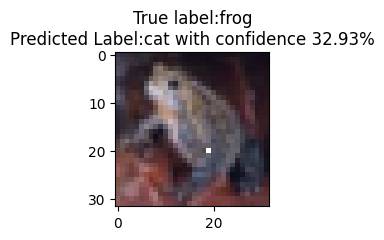

time for attacking this image: 76.17753405799886


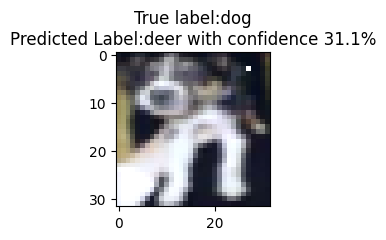

time for attacking this image: 60.85951951400057


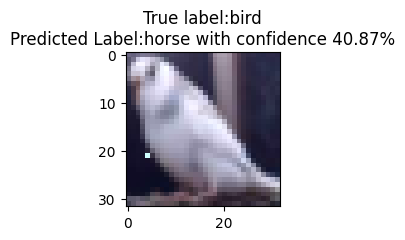

time for attacking this image: 32.76353905799624


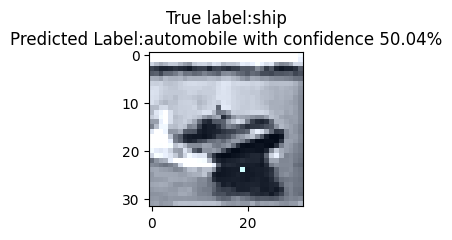

In [ ]:
for x in succ_att_t:
  i,p,t = x
  image = perturb_image(x_test_rn[i],p)
  #image = x_test_rn[i]
  t_label = y_test[i]
  pred = my_resnetmodel(preprocess(image))
  print('time for attacking this image:',t)
  plot_image(image, t_label, pred)# save = True, id=str(i)+'mod')
  #files.download('image'+str(i)+'mod.png')